# Gaia (E)DR3: corrección del punto cere de la paralaje

Este tutorial ilustra como pueden corregirse las paralajes de Gaia del sesgo de punto cero. En promedio las paralajes son $0.017 mas$ demasiado pequeñas, pero como puede verse en el artículo [Parallax bias versus magnitude, colour, and position, Lindegren et al (2021)](https://www.aanda.org/articles/aa/full_html/2021/05/aa39653-20/aa39653-20.html) este sesgo varia segun el tipo de solución astrométrica, la región del cielo, el color del objeto y su magnitud. En ese mismo artículo se desarrollaron herramientas en Python que permiten corregir este sesgo de forma individual para cada objeto teniendo en cuenta estas dependencias. El código Python para esta corrección está disponible en  [github](https://gitlab.com/icc-ub/public/gaiadr3_zeropoint) y este tutorial es una adaptación de los incluidos en el mismo.

El tutorial usa una muestra de estrellas de varios tipos extraida del archivo de Gaia usando este comando ADQL:

```
select * from gaiaedr3.gaia_source
where phot_g_mean_mag between 17.9 and 18.1
and random_index between 700000000 and 701000000
```

El fichero resultante (ZPrandomG18.csv) se incluye en este tutorial y contiene 21594 fuentes, con una mezcla de los tres tipos de soluciones astrométricas: 2-p, 5-p y 6-p. Pueden tambiñen adaptar este comando para trabajar con su propio fichero.

Al final de este tutorial se propone un ejercicio práctico usando cuásares.

<hr>

In [24]:
import numpy as np
import pandas as pd

import zpt
zpt.load_tables()

## Read the data

In [25]:
data = pd.read_csv('ZPrandomG18.csv')

gmag = data['phot_g_mean_mag'].values
nueffused = data['nu_eff_used_in_astrometry'].values
psc = data['pseudocolour'].values
ecl_lat = data['ecl_lat'].values
soltype = data['astrometric_params_solved'].values

## Blindly use the get_zpt function

Using the `get_zpt()` function blindly will fail if there are source with 2-p solutions in the input list. Thus the line of code below will lead to a runtime error.

In [5]:
zpvals = zpt.get_zpt(gmag, nueffused, psc, ecl_lat, soltype)

ValueError: Some of the sources have an invalid number of the astrometric_params_solved and are not one of the two 
            possible values (31,95). Please provide an acceptable value.

## Remove the 2-p solutions

Re-running the line of above with the 2-p solution removed works. The code automatically deals with a mix of 5-p and 6-p solutions. However, note the warning.

In [6]:
valid = soltype>3
zpvals = zpt.get_zpt(gmag[valid], nueffused[valid], psc[valid], ecl_lat[valid], soltype[valid])

C:\Google Drive\UB\Gaia\Congressos i reunions\Escuela LatAm 2022\Tutorials\Zero point\zpt.py:233: UserWarning: The pseudocolour of some of the 6p source(s) is outside the expected range (1.24-1.72 mag).
                 The maximum corrections are reached already at 1.24 and 1.72
  warnings.warn(


As explained in Lindegren et al. 2020, the interpolations are only calibrated within the following intervals:

1. $G$ magnitude: 
    6 < phot_g_mean_mag < 21
2. Colour:
    1. 1.1 < nu_eff_used_in_astrometry < 1.9 (5-p sources)
    2. 1.24 < pseudocolour < 1.72 (6-p sources)
        
Outside these ranges, the zero-point obtained is an **extrapolation**.

### Try turning off the warnings

This makes the code return NaN for the sources that fall outside the recomended limits, instead of an extrapolated zero point

In [7]:
valid = soltype>3
zpvals = zpt.get_zpt(gmag[valid], nueffused[valid], psc[valid], 
                     ecl_lat[valid], soltype[valid],_warnings=False)

## Try scalars as input

The code should also work for a single source. This is tested in the next code block.

In [8]:
#separate 5p and 6p sources
fivep = (soltype==31)
sixp = (soltype==95)

In [9]:
#query the zero-point for individual stars
zpvals5p = zpt.get_zpt(gmag[fivep][0], nueffused[fivep][0], psc[fivep][0], ecl_lat[fivep][0], soltype[fivep][0])
print(zpvals5p)
zpvals6p = zpt.get_zpt(gmag[sixp][0], nueffused[sixp][0], psc[sixp][0], ecl_lat[sixp][0], soltype[sixp][0])
print(zpvals6p)

-0.025076
-0.045967


## Mix of input variable lengths

*This should fail.*

In [10]:
zpvals5p = zpt.get_zpt(gmag[fivep][0], nueffused[fivep][0:2], psc[fivep][0], ecl_lat[fivep][0], soltype[fivep][0])
print(zpvals5p)

ValueError: Dimension mismatch! At least one of the inputs has a different shape than the rest.

## Using the Pandas wrapper

If you have pandas installed and work with DataFrames, you can use the wrapper provided with the package.

**NOTE**: This way of computing the zero point is slower than using the *get_zpt()* function. Also, it returns NaN outside interpolation limits.

In [11]:
data_valid = data.query('astrometric_params_solved>3').copy()

In [12]:
data_valid['zpt'] = data_valid.apply(zpt.zpt_wrapper,axis=1)

In [13]:
data_valid.zpt

0       -0.045967
1       -0.022748
2             NaN
3       -0.025076
4       -0.026733
           ...   
21589         NaN
21590   -0.026660
21591   -0.027001
21592   -0.026327
21593   -0.026660
Name: zpt, Length: 21283, dtype: float64

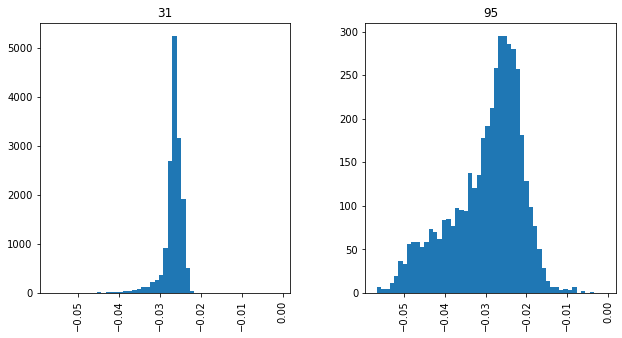

In [12]:
data_valid.hist(column='zpt',by='astrometric_params_solved',figsize=(10,5),sharex=True,bins=50);

## Ejercicio

La tabla _frame_rotator_source_ del archivo EDR3 de Gaia contiene una lista de identificadores para 429,249 fuentes que se han clasificado como cuásares. Cruzando esta tabla con la tabla principal de EDR3 _gaia_source_ podemos extraer la inforación que necesitamos para estos objetos:

    select QSO.source_id, G.parallax, G.parallax_error, G.phot_g_mean_mag, G.nu_eff_used_in_astrometry, 
           G.pseudocolour, G.ecl_lat, G.astrometric_params_solved
    from gaiaedr3.frame_rotator_source as QSO
    JOIN gaiaedr3.gaia_source as G
    using (source_id)

En este tutorial proporcionamos el resultado en el fichero _QSO_Data.csv_. 

Usando estos datos podemos comprobar como la corrección que hemos presentado elimina casi totalmente el sesgo de punto cero:

1. Hacer un histograma y un [QQ-plot](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html) de las paralajes normalizadas ($\varpi/\sigma_\varpi$) para comprobar que su distribución es muy aproximadamente normal 
2. Calcular la media de las paralajes sin corrección y con corrección 

En el primer caso la media es aproximadamente $-0.017mas$, mientras que en el segundo es casi cero. Con esto se comprueba la validez de la corrección, puesto que los cuásares (debido a su gran distancia) tienen paralajes de valor cero, por lo que la media debe acercarse a este valor.